In [38]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
from tqdm import tqdm
from tqdm import tnrange
%matplotlib inline

def cameraProperties():
    images = glob.glob("camera_cal/calibration*.jpg")
    image_size = []
    img_points = []
    obj_points = []
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for fname in tqdm(images):
        image = mpimg.imread(fname)
        gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
        ret,corners = cv2.findChessboardCorners(gray,(9,6),None)
        if ret == True:
            img_points.append(corners)
            obj_points.append(objp)
            image = cv2.drawChessboardCorners(image,(9,6),corners,ret)
            #cv2.imshow(fname,image)
            #cv2.waitKey(500)
            
    sample = cv2.imread(images[0])
    ret,camera_matrix,distortion_params,rvecs,tvecs = cv2.calibrateCamera(obj_points, img_points, sample.shape[1::-1],None,None)
    return camera_matrix,distortion_params

camera_mat,distort_para = cameraProperties()

100%|██████████| 20/20 [00:09<00:00,  2.13it/s]


In [39]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = [] 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def undistort_image(img, camera, dist):
    undis = cv2.undistort(img,camera,dist,None,camera)
    return undis

def abs_sobel_grad(img,sobel_kernel=3, operator_type='x', abs_thresh=(20,100)):
    in_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if operator_type == 'x':
        sobel = cv2.Sobel(in_gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(in_gray, cv2.CV_64F, 0, 1)
        
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1
    return sbinary

def mag_grad(img, sobel_kernel=3, mag_thresh=(30, 100)):
    in_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(in_gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(in_gray, cv2.CV_64F, 0, 1)
    grad_mag = np.sqrt(sobelx**2,sobely**2)
    scaled_sobel = np.uint8(255 * grad_mag/np.max(grad_mag))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, s_thresh=(170,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    return binary

def wrap(img):
    
    #define image size
    img_size = (img.shape[1],img.shape[0])
    
    #select source points
    srcpoint1 = (img.shape[1] * 0.440,img.shape[0] * 0.652) #top left
    srcpoint2 = (img.shape[1] * 0.560,img.shape[0] * 0.652) #top right
    srcpoint3 = (img.shape[1] * 0.830,img.shape[0] - 25) #bottom right
    srcpoint4 = (img.shape[1] * 0.185,img.shape[0] - 25) #bottom left
    
    #select destination points

    dstpoint1 = (320,0) #top left
    dstpoint2 = (960,0) #top right
    dstpoint3 = (960, img.shape[0]) #bottom left
    dstpoint4 = (320,img.shape[0]) #bottom right

    #create arrays for src and dst
    src = np.float32([srcpoint1,srcpoint2,srcpoint3,srcpoint4])
    dst = np.float32([dstpoint1,dstpoint2,dstpoint3,dstpoint4])
    
    #get Perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Min = cv2.getPerspectiveTransform(dst, src)
    
    #get wrapped image
    warped = cv2.warpPerspective(img, M, img_size)

    #return image
    return warped,Min

def curved_paths(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)
    out_img = np.dstack((img, img, img))*255
    #print(out_img.shape)
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2)     
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2)
        #cv2.imshow(str(window),out_img)
        #cv2.waitKey(500)
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    #for_display_only = np.uint8(out_img)
    #plt.imshow(for_display_only)
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)
    
    plt.savefig("curved_path.jpg")

    return out_img, ploty, left_fitx, right_fitx, left_fit, right_fit

def slidingWindowNew(img,left_fit_here,right_fit_here):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_here[0]*(nonzeroy**2) + left_fit_here[1]*nonzeroy + 
    left_fit_here[2] - margin)) & (nonzerox < (left_fit_here[0]*(nonzeroy**2) + 
    left_fit_here[1]*nonzeroy + left_fit_here[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_here[0]*(nonzeroy**2) + right_fit_here[1]*nonzeroy + 
    right_fit_here[2] - margin)) & (nonzerox < (right_fit_here[0]*(nonzeroy**2) + 
    right_fit_here[1]*nonzeroy + right_fit_here[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx, left_fit, right_fit

def getRadiusOfCurvature(ploty,leftlanehere,rightlanehere):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftlanehere*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightlanehere*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return left_curverad, right_curverad

def finalStep(img,ploty,left_fitx,right_fitx,Minv,undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

def plotColorImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plotBlackImage(img):
    plt.imshow(img, cmap='gray')
    

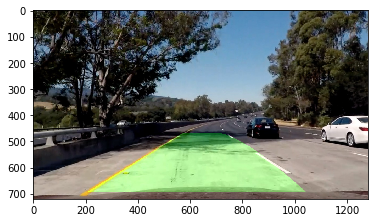

In [40]:
in_image = cv2.imread("test_images/test5.jpg")
undistroted_image = undistort_image(in_image,camera_mat,distort_para)
image_sobelx = abs_sobel_grad(undistroted_image, sobel_kernel=3, operator_type='x', abs_thresh=(20,100))
image_sobely = abs_sobel_grad(undistroted_image, sobel_kernel=3, operator_type='y', abs_thresh=(20,100))
image_sobelmag = mag_grad(undistroted_image, sobel_kernel=3, mag_thresh=(30,100))
image_sobeldir = dir_threshold(undistroted_image, sobel_kernel=3, dir_thresh=(0.7,1.3))
gradient_threshold = np.zeros_like(image_sobeldir)
gradient_threshold[((image_sobelx == 1) & (image_sobely == 1)) | ((image_sobelmag == 1) & (image_sobeldir == 1))] = 1

color_threshold = hls_select(undistroted_image)
combined_thresholds = np.zeros_like(gradient_threshold)
combined_thresholds[(color_threshold == 1) | (gradient_threshold == 1)] = 1

wrapped_image,Min = wrap(combined_thresholds)
path_image, plotter, leftlane, rightlane, polyFitLeft, polyFitRight = curved_paths(wrapped_image)
#plotter, leftlane, rightlane, polyFitLeft, polyFitRight = slidingWindowNew(wrapped_image,polyFitLeft,polyFitRight)
leftCurvature, rightCurvature = getRadiusOfCurvature(plotter, leftlane, rightlane)
result_image = finalStep(wrapped_image,plotter,leftlane,rightlane,Min,undistroted_image)
plotColorImage(result_image)

In [41]:
def process_image(image):
    
    undistroted_image = undistort_image(image,camera_mat,distort_para)
    image_sobelx = abs_sobel_grad(undistroted_image, sobel_kernel=3, operator_type='x', abs_thresh=(20,100))
    image_sobely = abs_sobel_grad(undistroted_image, sobel_kernel=3, operator_type='y', abs_thresh=(20,100))
    image_sobelmag = mag_grad(undistroted_image, sobel_kernel=3, mag_thresh=(30,100))
    image_sobeldir = dir_threshold(undistroted_image, sobel_kernel=3, dir_thresh=(0.7,1.3))
    gradient_threshold = np.zeros_like(image_sobeldir)
    gradient_threshold[((image_sobelx == 1) & (image_sobely == 1)) | ((image_sobelmag == 1) & (image_sobeldir == 1))] = 1

    color_threshold = hls_select(undistroted_image)
    combined_thresholds = np.zeros_like(gradient_threshold)
    combined_thresholds[(color_threshold == 1) | (gradient_threshold == 1)] = 1
    
    wrapped_image,Min = wrap(combined_thresholds)
    
    
    if len(leftLineInfo.recent_xfitted) >= avg_window:
        plotter, leftlane, rightlane, polyFitLeft, polyFitRight = slidingWindowNew(wrapped_image
                                                                                               ,leftLineInfo.current_fit
                                                                                               ,rightLineInfo.current_fit)
    
        result_image = finalStep(wrapped_image,plotter,leftLineInfo.bestx,rightLineInfo.bestx,Min,undistroted_image)
        leftCurvature, rightCurvature = getRadiusOfCurvature(plotter, leftLineInfo.bestx, rightLineInfo.bestx)
    else:
        path_image, plotter, leftlane, rightlane, polyFitLeft, polyFitRight = curved_paths(wrapped_image)
        leftCurvature, rightCurvature = getRadiusOfCurvature(plotter, leftlane, rightlane)
        result_image = finalStep(wrapped_image,plotter,leftlane,rightlane,Min,undistroted_image)
    
    
    leftLineInfo.recent_xfitted.append(leftlane)
    rightLineInfo.recent_xfitted.append(rightlane)
    leftLineInfo.best_fit.append(polyFitLeft)
    rightLineInfo.best_fit.append(polyFitRight)
    leftLineInfo.radius_of_curvature.append(leftCurvature)
    rightLineInfo.radius_of_curvature.append(rightCurvature)
    
    diff =  leftlane[-1] + ( (rightlane[-1] - leftlane[-1]) / 2 )
    leftLineInfo.line_base_pos = np.abs(image.shape[1]/2 - diff)
    rightLineInfo.line_base_pos = np.abs(image.shape[1]/2 - diff)
    
    if len(leftLineInfo.recent_xfitted) >= avg_window:
        leftLineInfo.bestx = np.mean( leftLineInfo.recent_xfitted[ ((-1)*(avg_window)) : ] , axis=0)
        rightLineInfo.bestx = np.mean( rightLineInfo.recent_xfitted[ ((-1)*(avg_window)) : ] ,axis=0)
        leftLineInfo.current_fit = np.mean(leftLineInfo.best_fit[ ((-1)*(avg_window)) : ],axis=0)
        rightLineInfo.current_fit = np.mean(rightLineInfo.best_fit[ ((-1)*(avg_window)) : ],axis=0)
        
        leftLineInfo.line_base_pos = np.abs( image.shape[1]/2 - leftLineInfo.bestx[-1] ) 
        rightLineInfo.line_base_pos = np.abs( image.shape[1]/2 - rightLineInfo.bestx[-1] )
    
    printString = "Radius of curvature Left[Km] : " + str(np.around(leftCurvature/1000,decimals=2))
    cv2.putText(result_image, printString ,(50,50), 20, 1,(0,0,255),2,cv2.LINE_AA)
    printString = "Radius of curvature Right[Km] : " + str(np.around(rightCurvature/1000,decimals=2))
    cv2.putText(result_image, printString ,(50,100), 20, 1,(0,0,255),2,cv2.LINE_AA) 
    printString = "Distance From Center[m] : " + str(np.around(leftLineInfo.line_base_pos * (3.7/700.0),decimals=2))
    cv2.putText(result_image, printString ,(50,150), 20, 1,(0,0,255),2,cv2.LINE_AA) 
    return result_image

In [37]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

avg_window = 10
leftLineInfo = Line()
rightLineInfo = Line()
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [06:31<00:00,  3.11it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 6min 22s, sys: 54.1 s, total: 7min 16s
Wall time: 6min 34s
